In [40]:
import torch
import random 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# loading dataset
words = open(r"data\names.txt").read().splitlines()
print(f"Number of words: {len(words)}")
print(f"first 5 words: {words[:5]}")

Number of words: 55272
first 5 words: ['parish', 'manhi', 'akshaykeerti', 'suran', 'tomali']


In [18]:
# creating a look up table (dictionary to map int to characters and vice versa)
chars = sorted(list(set(''.join(words))))
ch_to_id = {ch:i+1 for i, ch in enumerate(chars)}
ch_to_id['.'] = 0 # special char to mark ending and starting of a word

id_to_ch = {i:ch for ch, i in ch_to_id.items()}
print(f"Charecters to id: {ch_to_id}")
print(f"Id to charecters: {id_to_ch}")

Charecters to id: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Id to charecters: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [77]:
# building our datasets: training split(80%), dev/validation split(10%) and test split(10%)
# training split to train parameters
# dev split to tune hyperparameters
# test split to evaluate the model

block_size = 3 # context length: how many charecters to consider to predict the next charecter
def buid_dataset(words, str):
    
    X, Y = [], [] # X: context, Y: target
    
    for word in words:
        context = [0] * block_size
        for ch in word + ".": # adding a special char to mark the end of a word
            current_idx = ch_to_id[ch]
            X.append(context)
            Y.append(current_idx)
            context = context[1:] + [current_idx] # sliding the context window
            
    # converting the dataset to tensors        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"\nX_{str} shape: {X.shape}")
    print(f"Y_{str} shape: {Y.shape}")
    return X, Y

random.shuffle(words)
lim1 = int(len(words) * 0.8)
lim2 = int(len(words) * 0.9)

X_train, Y_train = buid_dataset(words[:lim1], "train")
X_dev, Y_dev = buid_dataset(words[lim1:lim2], "dev")
X_test, Y_test = buid_dataset(words[lim2:], "test")


X_train shape: torch.Size([401485, 3])
Y_train shape: torch.Size([401485])

X_dev shape: torch.Size([50160, 3])
Y_dev shape: torch.Size([50160])

X_test shape: torch.Size([50322, 3])
Y_test shape: torch.Size([50322])


In [78]:
# dataset insights
print(f"X_train shape: {X_train.shape} & Y_train shape: {Y_train.shape}")
print(f"X_train dtype: {X_train.dtype} & Y_train dtype: {Y_train.dtype}")
print(f"X_train[:5]: {X_train[:5]}")
print(f"Y_train[:5]: {Y_train[:5]}")

X_train shape: torch.Size([401485, 3]) & Y_train shape: torch.Size([401485])
X_train dtype: torch.int64 & Y_train dtype: torch.int64
X_train[:5]: tensor([[ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19,  1],
        [19,  1,  1],
        [ 1,  1, 25]])
Y_train[:5]: tensor([19,  1,  1, 25,  1])


In [134]:
# embedding our 27 charecters into a 10 dimentional space hence every charecter will be represented by a 10 dimentional vector(embedding)
# look up table for embedding
C = torch.randn((27, 10))
embeddings = C[X_train] # magic fo pytorch indexing to simultaneously embed all individual chars from X

In [135]:
print(f"First 5 embeddings in C: {C[:5]}")
print(f"\nShape of embeddings: {embeddings.shape}")
print(f"\nFirst 5 embeddings in X: {embeddings[:5]}")

First 5 embeddings in C: tensor([[ 0.9977,  1.6354,  1.0069,  0.0662, -1.6079, -0.5990, -0.9789, -0.3410,
         -0.6607, -0.5154],
        [-1.2007, -1.2290, -0.1421, -1.2987, -0.2009, -0.1546,  0.4579, -0.4722,
         -0.2444,  2.3007],
        [ 0.8112, -2.0365, -1.4293,  1.2816, -2.0307, -0.8626, -0.0788, -0.4361,
         -0.4600,  0.1418],
        [ 1.1363, -0.2184, -1.6287,  0.1124,  1.0585,  0.6096,  0.1990, -0.1760,
         -0.2332,  1.0673],
        [-0.1152, -1.2596,  0.6201,  0.3687, -0.6985, -0.9306,  0.1795,  2.2529,
         -0.8909,  0.9076]])

Shape of embeddings: torch.Size([401485, 3, 10])

First 5 embeddings in X: tensor([[[ 0.9977,  1.6354,  1.0069,  0.0662, -1.6079, -0.5990, -0.9789,
          -0.3410, -0.6607, -0.5154],
         [ 0.9977,  1.6354,  1.0069,  0.0662, -1.6079, -0.5990, -0.9789,
          -0.3410, -0.6607, -0.5154],
         [ 0.9977,  1.6354,  1.0069,  0.0662, -1.6079, -0.5990, -0.9789,
          -0.3410, -0.6607, -0.5154]],

        [[ 0.9977,

In [137]:
# constructing our only hidden layer
# the number of inputs is 3 (block size) * 2 (embedding dimention) = 6 and 200 is the number of neurons in the hidden layer
W1 = torch.randn((30, 200))
b1 = torch.randn((200))

# in order to carry out embedding @ W1 + b1 we need to concatenate the embeddings along the embedding dimention
# can be done using using cat() or view() or reshape() methods:
# method 1: using cat()
# embeddings = torch.cat(torch.unbind(embeddings, dim=1), dim=1) # here the unbind method splits the embeddings along the embedding dimention
# method 2: using view() - most efficient way as it doesn't create a copy of the tensor

# hidden states with tanh non-linearity
hidden_layer_output = torch.tanh((embeddings.view(-1, 30) @ W1) + b1)

print(f"Shape of hidden layer output: {hidden_layer_output.shape}")
hidden_layer_output

Shape of hidden layer output: torch.Size([401485, 200])


tensor([[ 0.9894,  0.9569,  1.0000,  ..., -0.9999, -1.0000, -0.9999],
        [ 1.0000, -1.0000,  0.9989,  ..., -0.9271, -0.9885, -0.9979],
        [ 0.9860, -0.9999,  0.8633,  ..., -1.0000,  0.8138, -1.0000],
        ...,
        [ 1.0000, -0.9940,  1.0000,  ...,  0.9883,  0.8922, -0.9827],
        [ 0.9964,  0.9993, -0.9923,  ...,  0.9996, -1.0000,  1.0000],
        [ 1.0000,  0.9900,  1.0000,  ..., -0.9994,  1.0000,  0.3707]])

In [138]:
# constructing the output layer
W2 = torch.randn((200, 27)) # 27 is the number of charecters in our dataset and 100 is input to the output layer
b2 = torch.randn((27))

# output of the output layer
logits = (hidden_layer_output @ W2) + b2

print(f"Output shape: {logits.shape}")
logits

Output shape: torch.Size([401485, 27])


tensor([[ -4.5605,  -0.6440,  -5.4997,  ...,   3.2886,   1.5744,  -7.6374],
        [-10.0704, -16.3868, -21.8381,  ...,  14.4929,  -3.9929,  -7.9951],
        [-22.2669,  -4.5684,   1.2623,  ..., -22.7771,  -5.9942,  -6.1266],
        ...,
        [  3.8155,   1.1894,  18.9159,  ...,   1.9546, -17.6228,  -7.0846],
        [ -8.6578,   2.3486, -17.6796,  ...,   4.7250, -19.1138,   7.3033],
        [  9.4232,  11.0050,   9.1159,  ...,   9.8825,  -5.4808,   4.1563]])

In [139]:
# softmax over the logits to get the probabilities
exp_logits = logits.exp()
probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)

print(f"Probabilities shape: {probs.shape}")
probs

Probabilities shape: torch.Size([401485, 27])


tensor([[1.4409e-14, 7.2366e-13, 5.6329e-15,  ..., 3.6936e-11, 6.6524e-12,
         6.6428e-16],
        [1.7879e-16, 3.2296e-19, 1.3857e-21,  ..., 8.3178e-06, 7.7939e-14,
         1.4243e-15],
        [1.6325e-22, 7.9287e-15, 2.7004e-12,  ..., 9.8011e-23, 1.9054e-15,
         1.6692e-15],
        ...,
        [1.3462e-14, 9.7413e-16, 4.8658e-08,  ..., 2.0939e-15, 6.5856e-24,
         2.4847e-19],
        [1.4618e-14, 8.8084e-10, 1.7650e-18,  ..., 9.4833e-09, 4.2065e-19,
         1.2494e-07],
        [3.9960e-07, 1.9436e-06, 2.9387e-07,  ..., 6.3255e-07, 1.3456e-13,
         2.0617e-09]])

In [140]:
parameters = [C, W1, b1, W2, b2]
for param in parameters:
    param.requires_grad = True

num_params = sum(p.nelement() for p in parameters)
print(f"Number of parameters: {num_params}")

# negative log likelihood loss fn: loss  = -probs[range(len(Y)), Y].log().mean()
loss = F.cross_entropy(logits, Y_train)
print(f"Loss: {loss}")

Number of parameters: 11897
Loss: 27.762474060058594


In [141]:
# stats to track
steps = []
steps_loss = []

In [153]:
# training on mini batches
batch_size = 32
alpha = 0.001
num_epochs = 50000

for epoch in range(num_epochs):
    # selecting random indices for the mini batch
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    
    # forward pass
    embeddings = C[X_train[idx]] # shape: (batch_size, 3, 2)
    hidden_layer_output = torch.tanh((embeddings.view(-1, 30) @ W1) + b1) # shape: (batch_size, 100)
    logits = (hidden_layer_output @ W2) + b2 # shape: (batch_size, 27)
    loss = F.cross_entropy(logits, Y_train[idx])
    
    if (epoch + 1) % 10000 == 0:
        print(f"Epoch: {epoch+1} | Loss: {loss}")
    
    # backward pass
    for param in parameters:
        param.grad = None
    loss.backward()
    # updating the parameters
    for param in parameters:
        param.data += -alpha * param.grad
        
    # saving the loss and steps
    steps.append(epoch+1)
    steps_loss.append(loss.log10().item()) # log10 to avoid very small values
print(f"Loss after training: {loss}")

Epoch: 10000 | Loss: 1.9835788011550903
Epoch: 20000 | Loss: 1.753211259841919
Epoch: 30000 | Loss: 1.8775767087936401
Epoch: 40000 | Loss: 2.0037198066711426
Epoch: 50000 | Loss: 1.8630813360214233
Loss after training: 1.8630813360214233


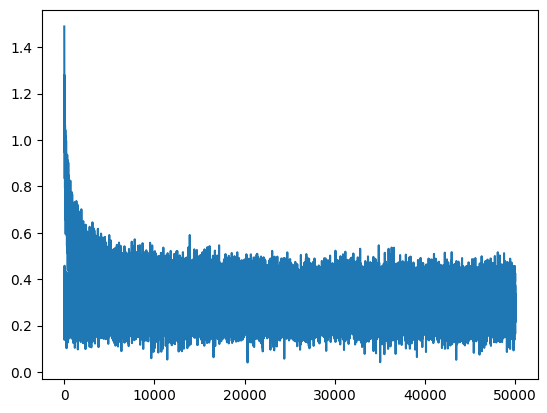

In [154]:
# plotting loss
plt.plot(steps, steps_loss)

In [155]:
# calculating the overall loss
embeddings = C[X_dev]
hidden_layer_output = torch.tanh((embeddings.view(-1, 30) @ W1) + b1)
logits = (hidden_layer_output @ W2) + b2
loss = F.cross_entropy(logits, Y_dev)
print(f"Validation Loss: {loss}")

Validation Loss: 1.9908475875854492


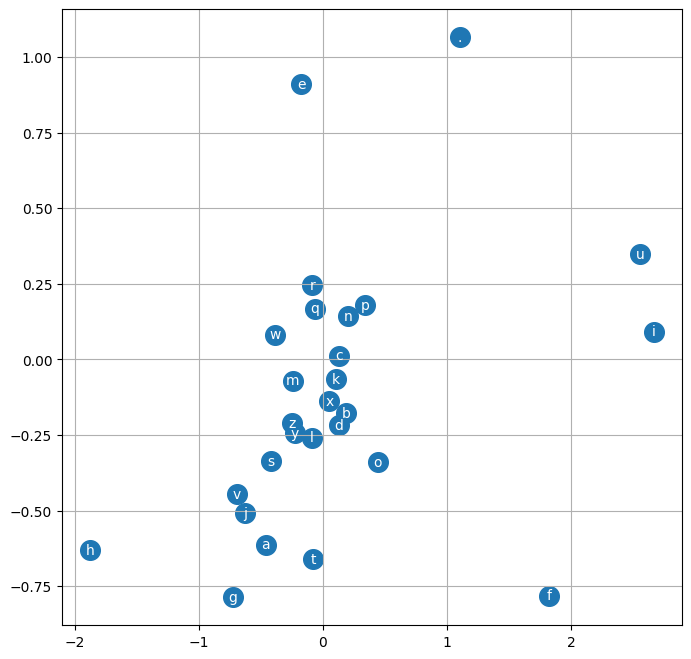

In [156]:
# visualizing trained embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), id_to_ch[i], ha='center', va='center', color='white')
plt.grid("minor")

In [168]:
# sampling from the model (generating new names)
g = torch.Generator()
predicted_names = []
block_size = 3

for _ in range(20):
    name = ""
    context = [0] * block_size
    while True:
        embeddings = C[torch.tensor(context)]
        hidden_layer_output = torch.tanh((embeddings.view(1, -1) @ W1) + b1)
        logits = (hidden_layer_output @ W2) + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        if idx != 0:
            name += id_to_ch[idx]
        else:
            predicted_names.append(name)
            break
predicted_names

['chita',
 'priyi',
 'hyitteavan',
 'vaaneshanuruki',
 'amaseya',
 'shani',
 'tanuma',
 'maabar',
 'lishni',
 'tar',
 'shaanibhagavindansh',
 'elaapisha',
 'mohita',
 'ipsha',
 'bha',
 'prashana',
 'gununa',
 'prathushagu',
 'muka',
 'nikshan']